In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Fake_News Data


In [13]:
#Loading the data
fake_news_df = pd.read_csv("/content/fake_news.csv")
fake_news.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [9]:
# Checking the descriptive statistics of the dataset
print(fake_news.describe())

                 id         label
count  20800.000000  20800.000000
mean   10399.500000      0.500625
std     6004.587135      0.500012
min        0.000000      0.000000
25%     5199.750000      0.000000
50%    10399.500000      1.000000
75%    15599.250000      1.000000
max    20799.000000      1.000000


In [10]:
# Checking the first few rows of the dataset
print(fake_news.head())

   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  


In [11]:
# Checking the data types and missing values
print(fake_news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
None


# EDA: Distribution of target variable

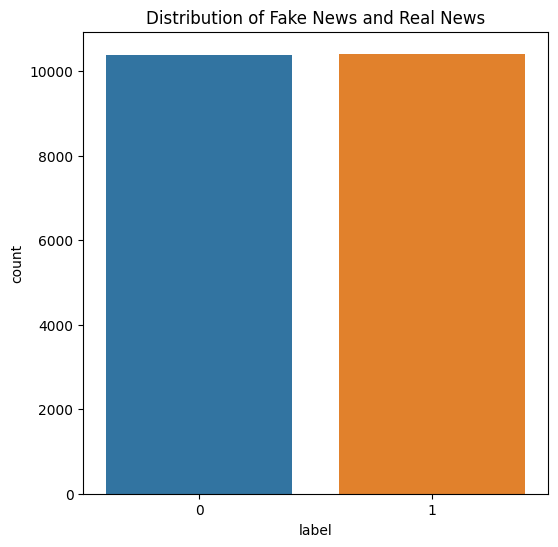

In [12]:
# Checking the distribution of the target variable
plt.figure(figsize=(6,6))
sns.countplot(x='label', data=fake_news)
plt.title('Distribution of Fake News and Real News')
plt.show()

We can see that our data is pretty balanced!

In [14]:
#Data Cleaning
# replace NaN values in 'title' and 'text' with 'missing'
fake_news_df['title'].fillna('missing', inplace=True)
fake_news_df['text'].fillna('missing', inplace=True)

# replace NaN values in 'author' with 'unknown'
fake_news_df['author'].fillna('unknown', inplace=True)

# EDA

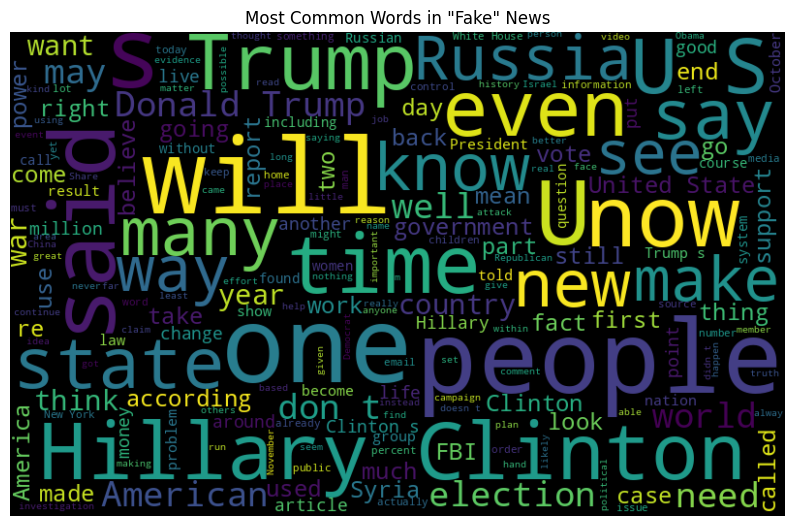

In [17]:
# Separate text data for 'fake' and 'real' news
fake_text = ' '.join(fake_news_df[fake_news_df['label']==1]['text'])
real_text = ' '.join(fake_news_df[fake_news_df['label']==0]['text'])

# Generate word cloud for 'fake' news
wordcloud_fake = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(fake_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis('off')
plt.title('Most Common Words in "Fake" News')
plt.show()

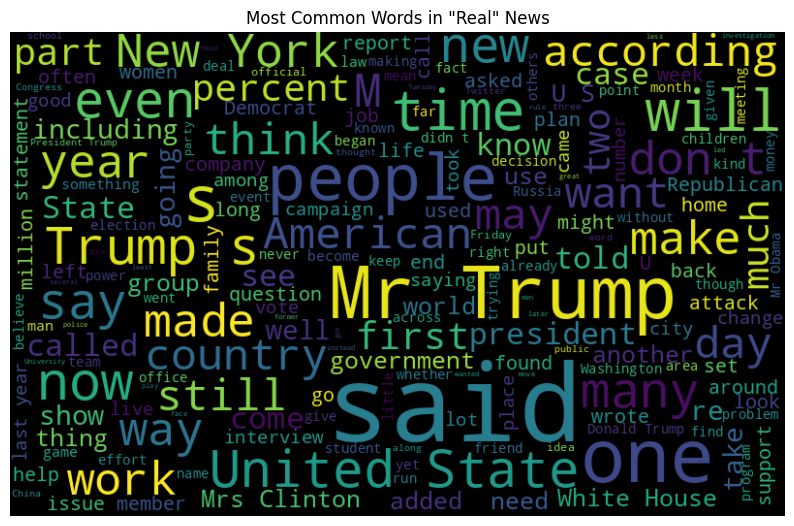

In [18]:
# Generate word cloud for 'real' news
wordcloud_real = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(real_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_real, interpolation="bilinear")
plt.axis('off')
plt.title('Most Common Words in "Real" News')
plt.show()

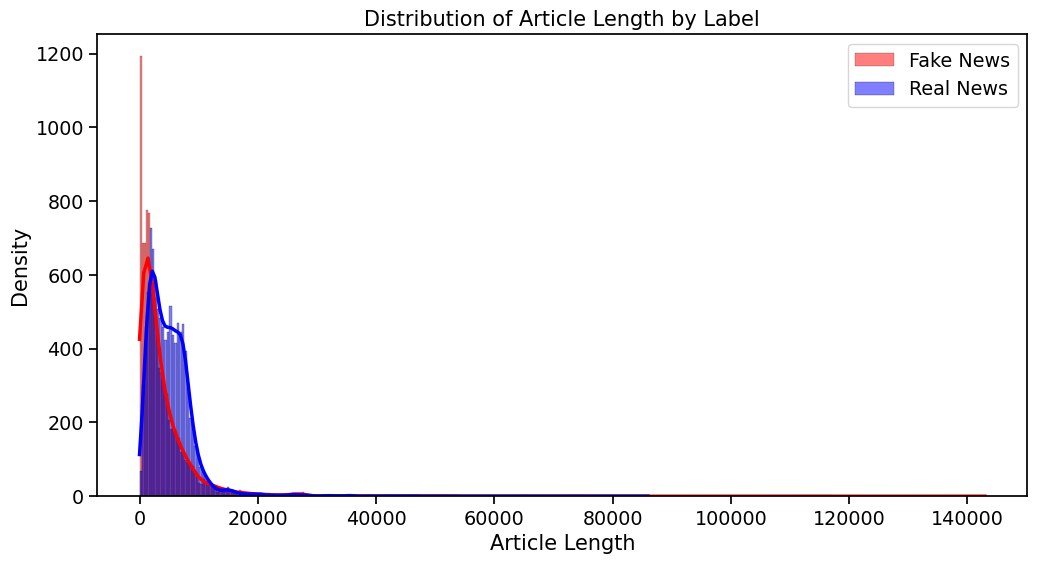

In [23]:
#Text Length Distribution by Label:
# Create separate dataframes for fake and real news
fake_news = fake_news_df[fake_news_df['label']==1]
real_news = fake_news_df[fake_news_df['label']==0]

# Plot the distribution of article length for each label
plt.figure(figsize=(12,6))
sns.histplot(fake_news['total_length'], color='red', kde=True, label='Fake News')
sns.histplot(real_news['total_length'], color='blue', kde=True, label='Real News')
plt.title('Distribution of Article Length by Label')
plt.xlabel('Article Length')
plt.ylabel('Density')
plt.legend()
plt.show()


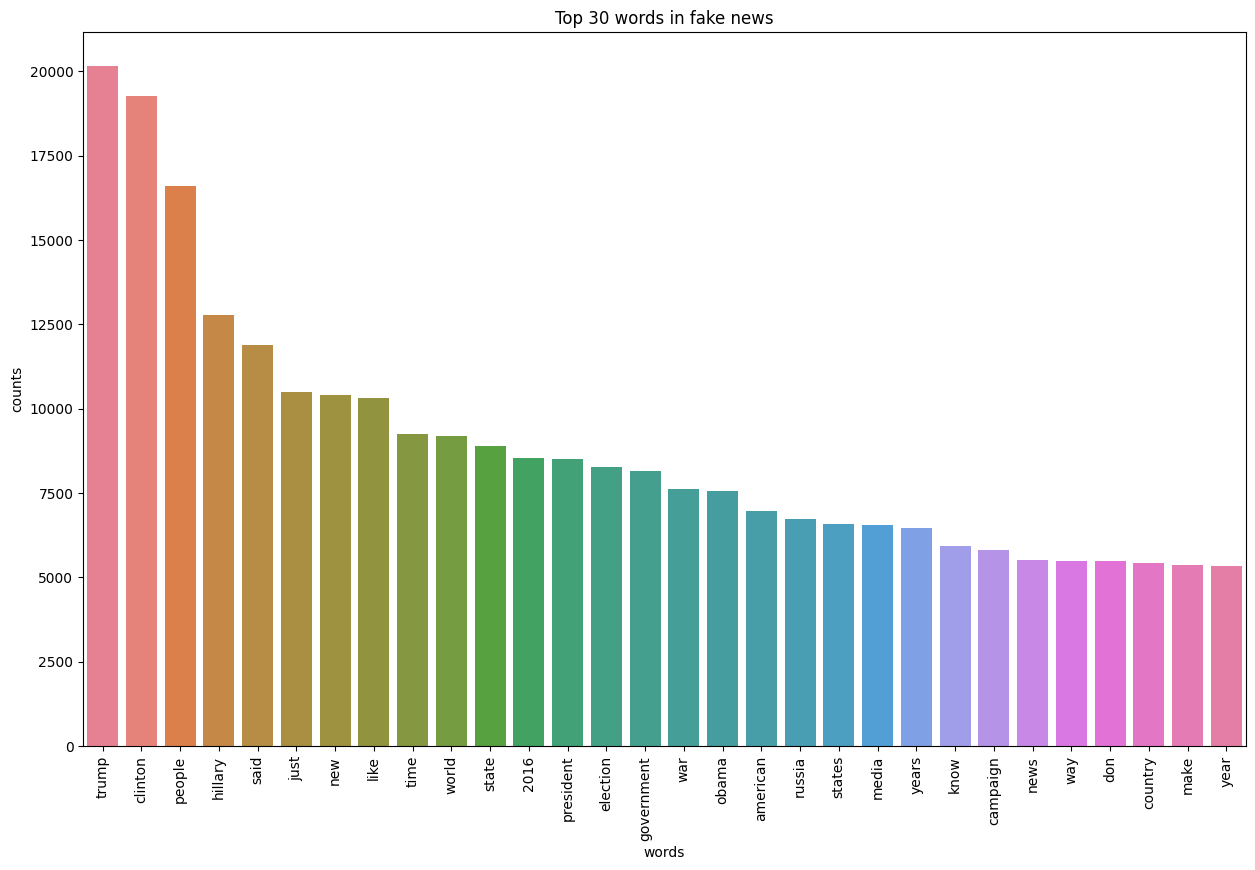

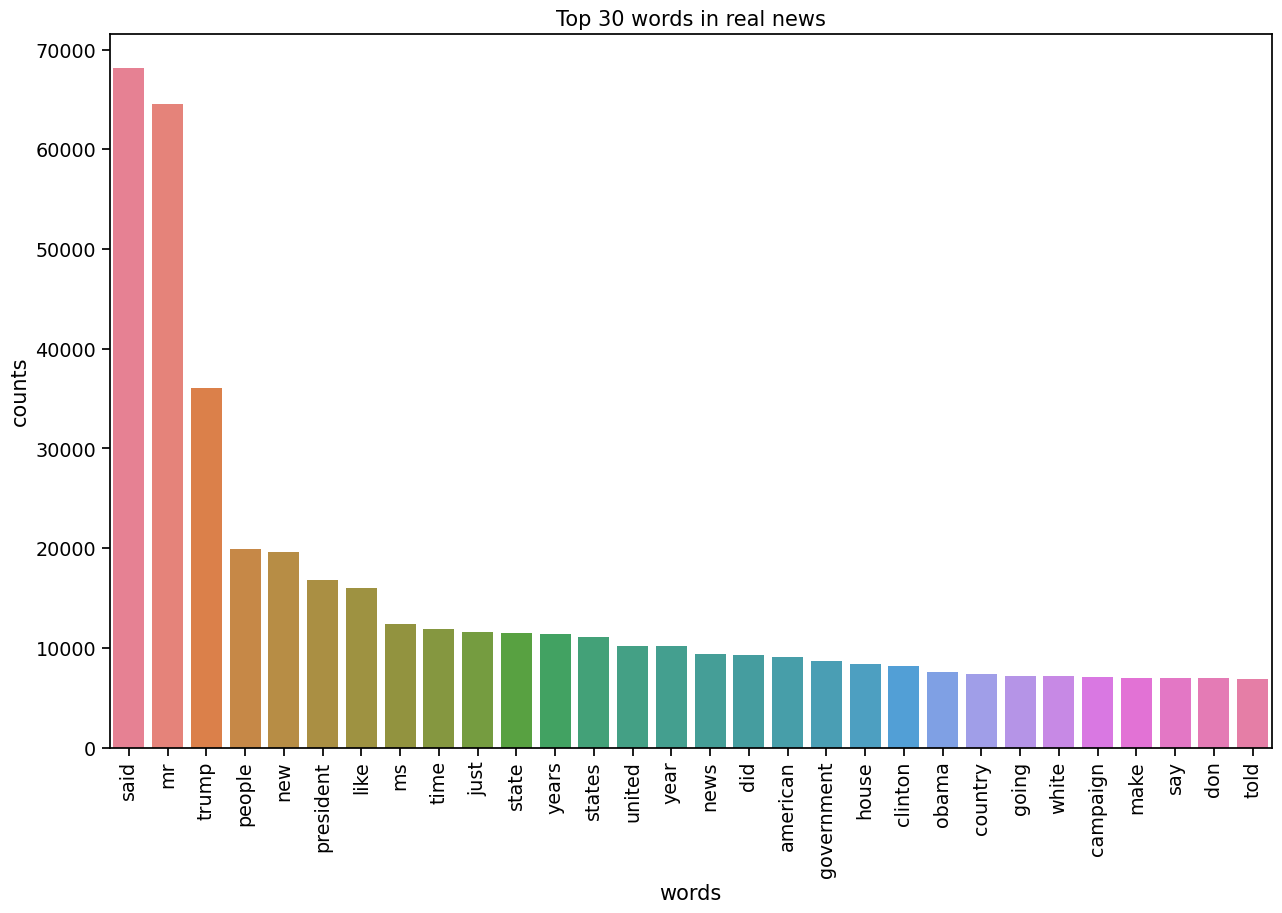

In [20]:
#Bar Plot of the Most Frequent Words
def plot_top_n_words(n, text, title):
    count_vectorizer = CountVectorizer(stop_words='english')
    count_data = count_vectorizer.fit_transform(text)

    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))

    for t in count_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=words, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Separate text data for 'fake' and 'real' news
fake_text = fake_news_df[fake_news_df['label']==1]['text']
real_text = fake_news_df[fake_news_df['label']==0]['text']

# Plot top n words for 'fake' and 'real' news
plot_top_n_words(30, fake_text, 'Top 30 words in fake news')
plot_top_n_words(30, real_text, 'Top 30 words in real news')

# EDA: Distribution of article lengths

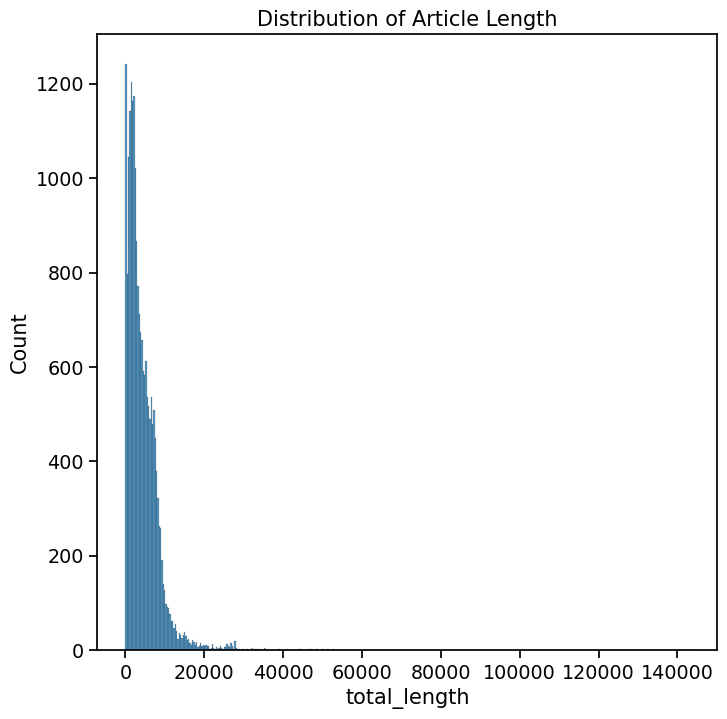

In [22]:
# Creating a new column 'total_length' to hold the length of each article
fake_news_df['total_length'] = fake_news_df['text'].apply(len)

# Plotting the distribution of the lengths
plt.figure(figsize=(8,8))
sns.histplot(fake_news_df['total_length']).set_title('Distribution of Article Length')
plt.show()


unknown                1957
Pam Key                 243
admin                   193
Jerome Hudson           166
Charlie Spiering        141
John Hayward            140
Katherine Rodriguez     124
Warner Todd Huston      122
Ian Hanchett            119
Breitbart News          118
Name: author, dtype: int64


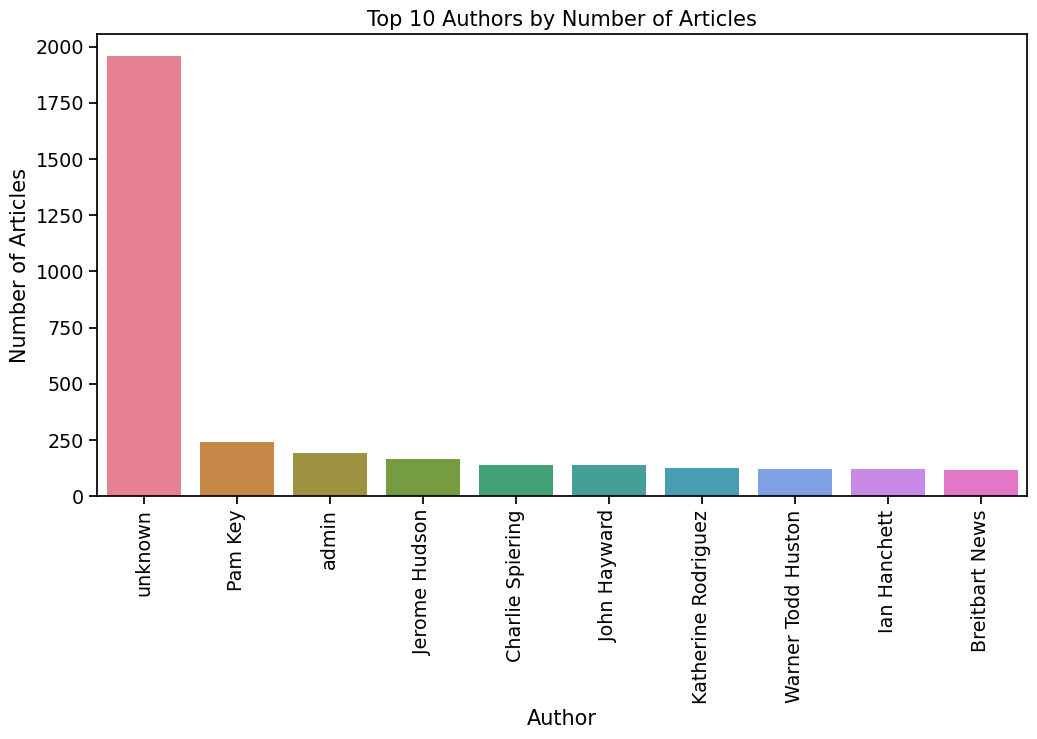

In [24]:
#Author Analysis:
# Count the number of articles by each author
author_counts = fake_news_df['author'].value_counts()

# Display the top 10 authors
print(author_counts[:10])

# Plot the number of articles by the top 10 authors
plt.figure(figsize=(12,6))
sns.barplot(x=author_counts[:10].index, y=author_counts[:10].values, palette='husl')
plt.title('Top 10 Authors by Number of Articles')
plt.xlabel('Author')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.show()


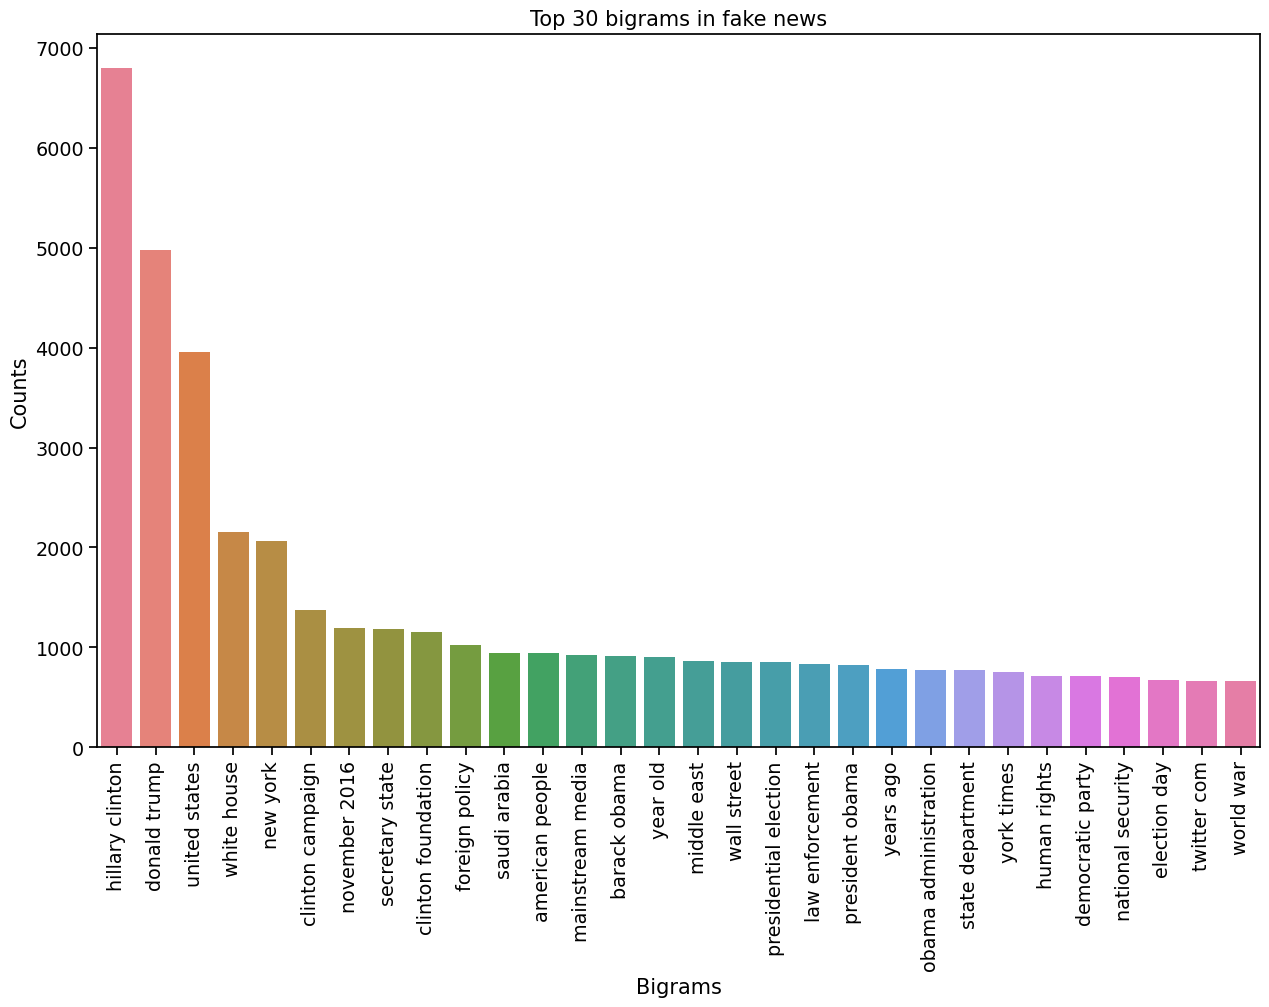

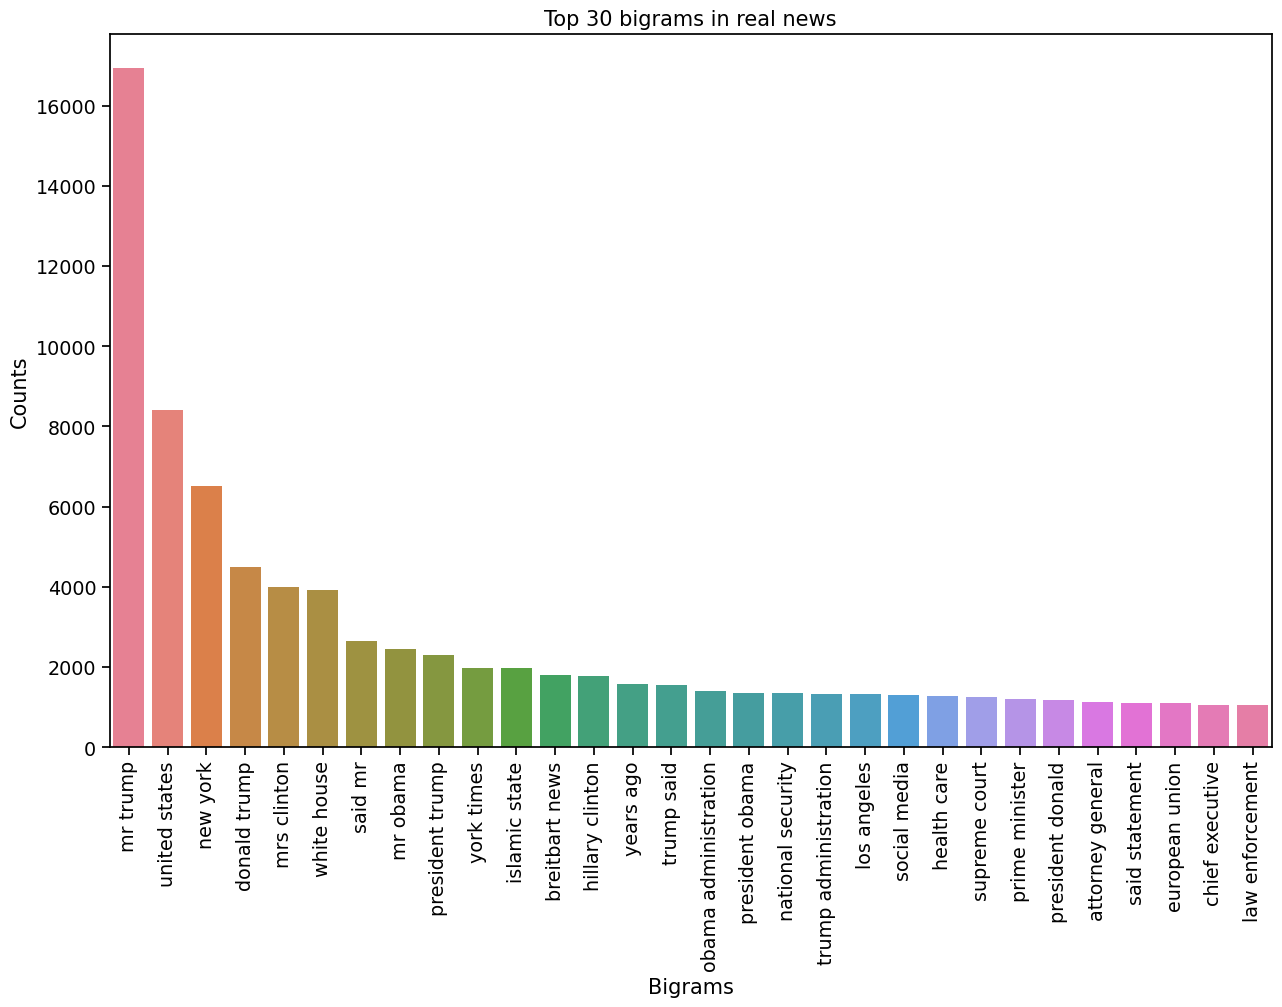

In [25]:
#Bigrams Analysis:


# Function to plot top n bigrams
def plot_top_n_bigrams(n, text, title):
    count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
    count_data = count_vectorizer.fit_transform(text)

    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))

    for t in count_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=words, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('Bigrams')
    plt.ylabel('Counts')
    plt.show()

# Plot top n bigrams for fake and real news
plot_top_n_bigrams(30, fake_news['text'], 'Top 30 bigrams in fake news')
plot_top_n_bigrams(30, real_news['text'], 'Top 30 bigrams in real news')


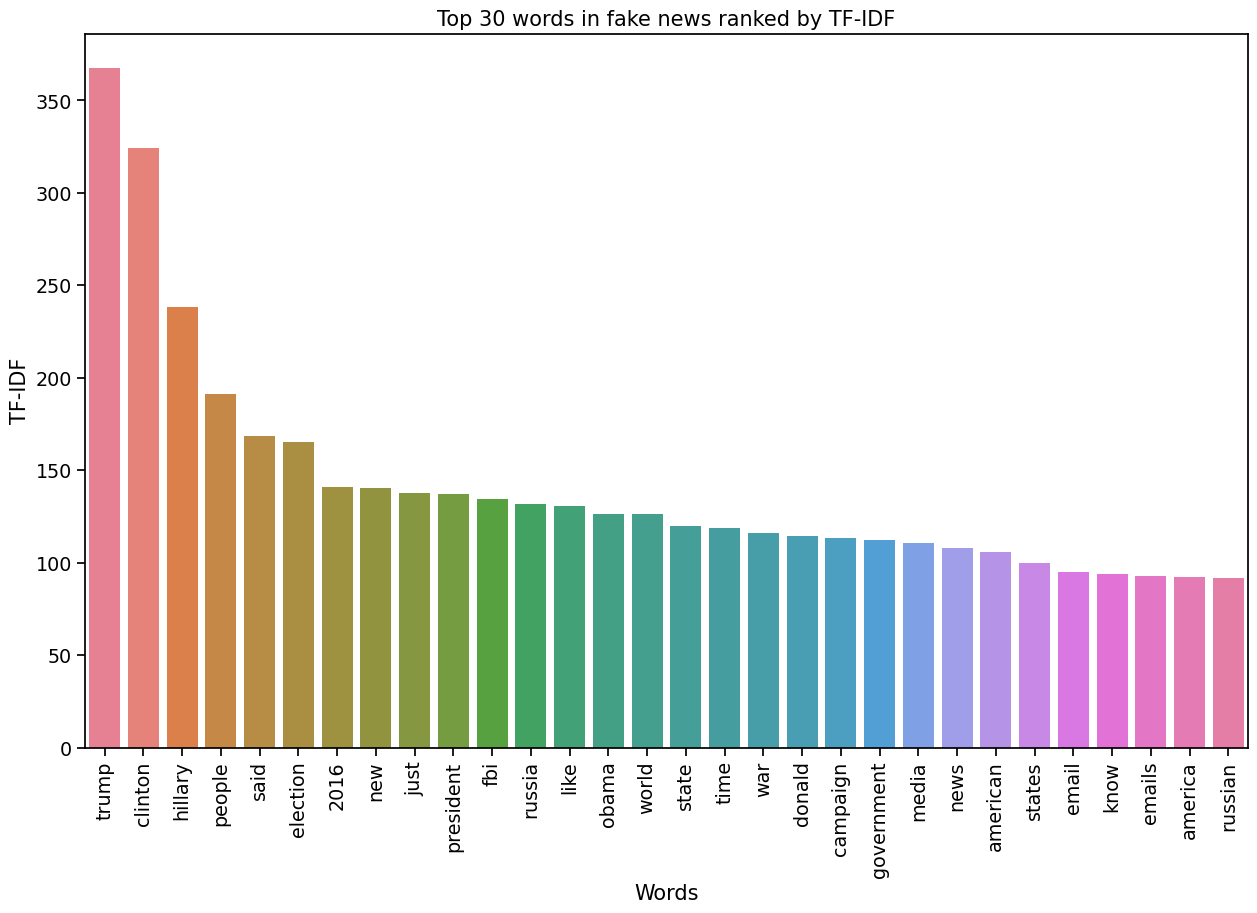

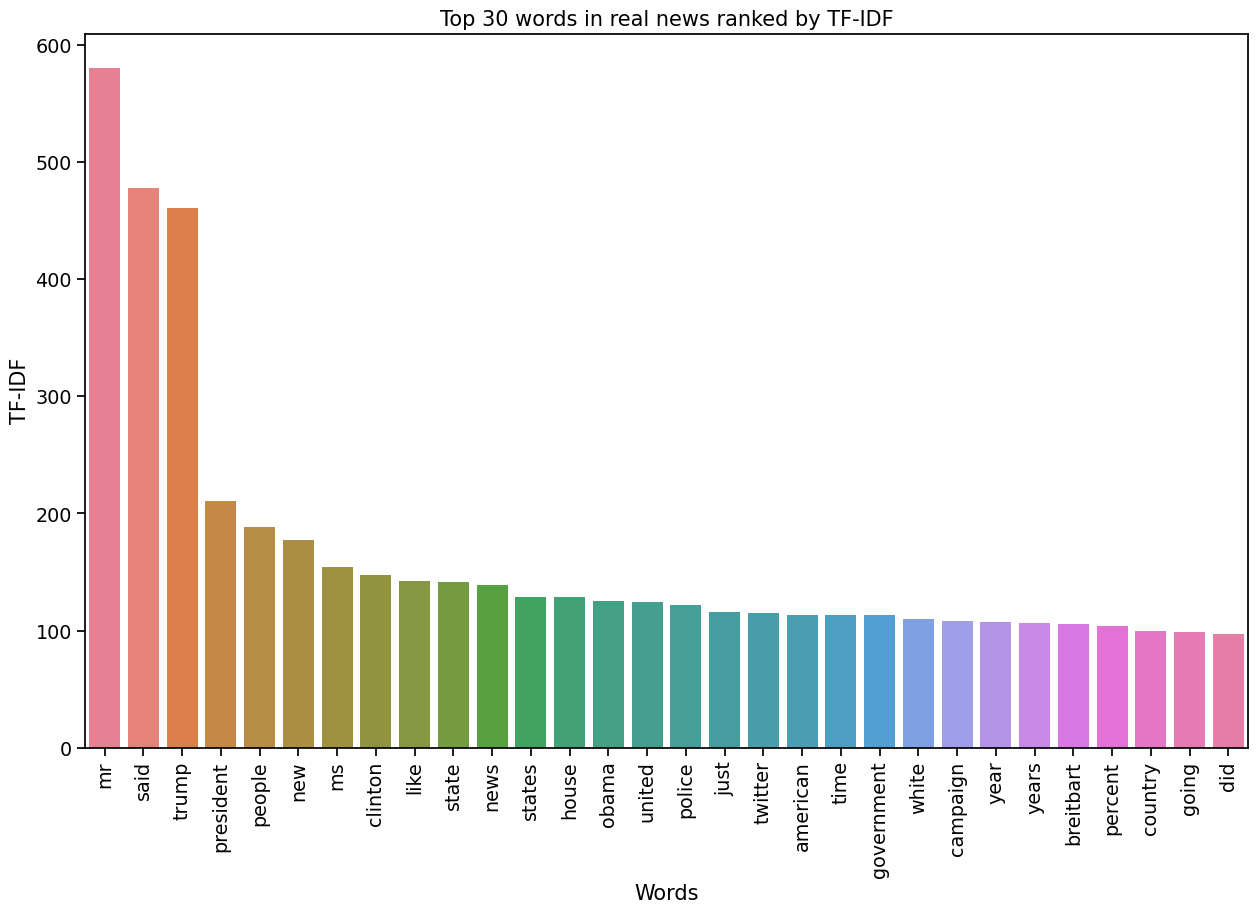

In [26]:
#TF-IDF Analysis:
# Function to calculate and plot top n words ranked by TF-IDF
def plot_top_n_tfidf(n, text, title):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_data = tfidf_vectorizer.fit_transform(text)

    words = tfidf_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))

    for t in tfidf_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=words, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('Words')
    plt.ylabel('TF-IDF')
    plt.show()

# Plot top n words ranked by TF-IDF for fake and real news
plot_top_n_tfidf(30, fake_news['text'], 'Top 30 words in fake news ranked by TF-IDF')
plot_top_n_tfidf(30, real_news['text'], 'Top 30 words in real news ranked by TF-IDF')